In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import random
import numpy as np

In [4]:
import os

In [5]:
class DatasetSplitter:
    
    def __init__(self, d_ratios: dict[str, float]):
        assert sum(d_ratios.values()) == 1.0
        self.d_ratios = d_ratios
        
    def split(self, old_path, new_path):
        ratios_names = list(self.d_ratios.keys())
        ratios = list(self.d_ratios.values())
        ratios_name2index = {ratios_name:i for i, ratios_name in enumerate(ratios_names)}
        
        classes = list(filter(
                        lambda path: os.path.isdir(os.path.join(old_path, path)), 
                        os.listdir(old_path))
        )
        classes_data = {
            class_dir: os.listdir(os.path.join(old_path, class_dir))
                for class_dir in classes
        }
        for class_name, data in classes_data.items():
            np.random.shuffle(data)        
        classes_count = {class_dir: len(classes_data[class_dir]) 
                            for class_dir in classes}
        cum_ratios = np.cumsum([0] + ratios)
        classes_borders = {class_dir: (cum_ratios * classes_count[class_dir]).astype(int)
                            for class_dir in classes}
        
        if not os.path.exists(new_path):
            os.mkdir(new_path)
            
        for ratios_name in ratios_names:
            ratio_path = os.path.join(new_path, ratios_name)
            if not os.path.exists(ratio_path):
                os.mkdir(ratio_path)
                
            for class_name in classes:
                class_path = os.path.join(new_path, ratios_name, class_name)
                if not os.path.exists(class_path):
                    os.mkdir(class_path)
                     
        for class_name in classes:
            for ratios_name in ratios_names:
                files_path = os.path.join(new_path, ratios_name, class_name) 
                border_index = ratios_name2index[ratios_name]
                start, end = classes_borders[class_name][border_index:border_index + 2]
                for file_idx in range(start, end):
                    file_name = classes_data[class_name][file_idx]
                    os.symlink(os.path.join(old_path, class_name, file_name),
                              os.path.join(new_path, ratios_name, class_name, file_name)
                              )

In [6]:
splitter = DatasetSplitter({"train": 0.8 * 0.7,
                 "val": 0.8 * 0.3,
                 "test": 0.2
                })

In [7]:
!ls /kaggle/working/in-out_dataset/val/indoor | wc -l

ls: cannot access '/kaggle/working/in-out_dataset/val/indoor': No such file or directory
0


In [8]:
splitter.split("/kaggle/input/indoor-outdoor", "/kaggle/working/in-out_dataset")

In [9]:
dataset_path = "/kaggle/working/in-out_dataset"

In [10]:
from PIL import Image


class InoutDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, target_transform):
        self.path = path
        self.transform = transform
        self.target_transform = target_transform
        
        self.classes = os.listdir(path)
        self.class2indexes = {}
        self.files = []
        self.count = 0
        
        for class_name in self.classes:
            files = os.listdir(os.path.join(self.path, class_name))
            cur = len(files)
            
            self.class2indexes[class_name] = (self.count, self.count + cur)
            self.files += files
            self.count += cur
            
    def get_class(self, index):
        for class_name, ranges in self.class2indexes.items():
            start, end = ranges
            if start <= index < end:
                return class_name
        return None
        
    def __len__(self):
        return self.count
        
    def __getitem__(self, index):
        class_name = self.get_class(index)
        path = os.path.join(self.path, class_name, self.files[index])
        im = self.transform(Image.open(path))
        target = self.target_transform(class_name)
        return im, target

In [11]:
target_transform = lambda x: int(x == 'indoor')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


train_data = InoutDataset(os.path.join(dataset_path, "train"), transform=transform, target_transform=target_transform)
val_data = InoutDataset(os.path.join(dataset_path, "val"), transform=transform, target_transform=target_transform)
test_data = InoutDataset(os.path.join(dataset_path, "test"), transform=transform, target_transform=target_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

outdoor


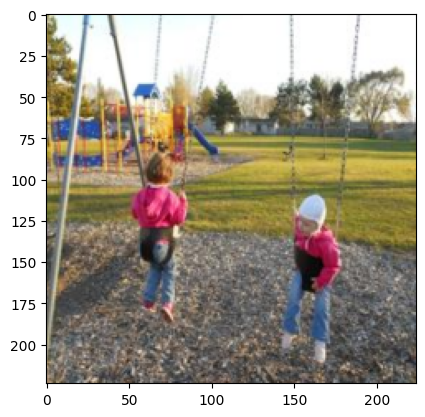

outdoor


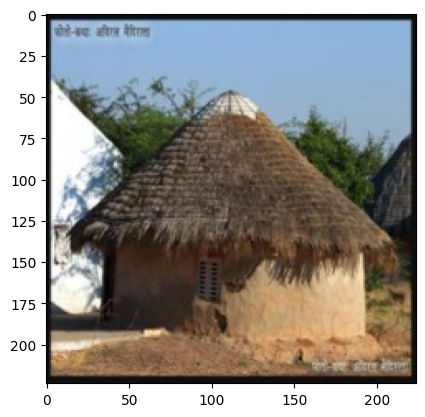

In [12]:
import matplotlib.pyplot as plt

print(train_data.get_class(0))
plt.imshow(train_data[0][0].permute(1, 2, 0))
plt.show()

print(train_data.get_class(200000))
plt.imshow(train_data[200000][0].permute(1, 2, 0))
plt.show()

In [13]:
def train(data, model, optimizer, n_epochs=20, steps_per_epoch=500, device='cuda'):
    train_dataloader = data['train']
    val_dataloader = data['val']
    model = model.to(device)
    accuracies, losses = [], []
    for epoch in range(n_epochs):
        model.train()
        for step, (x_train, y_train) in tqdm(enumerate(train_dataloader)):
            if step >= steps_per_epoch:
                break            
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        val_loss = []
        val_accuracy = []
        model.eval()
        with torch.no_grad():
            for step, (x_val, y_val) in tqdm(enumerate(val_dataloader)):
                if step >= steps_per_epoch:
                    break                  
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.cpu().numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        accuracies.append(np.mean(val_accuracy))
        losses.append(np.mean(val_loss))
        print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
    return accuracies, losses

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, f1_score, accuracy_score
def evaluate(test_loader, model, device='cuda'):

    y_true = []
    y_preds_proba = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for step, (x_test, y_test) in enumerate(tqdm(test_loader)):
            x_test = x_test.to(device)
            y_test = y_test.to(device)     
            y_pred = model(x_test).to(device)
            y_preds_proba.append(y_pred[:, 1].cpu())
            y_true.append(y_test.cpu())
        
    y_true = torch.hstack(y_true)
    y_preds_proba = torch.hstack(y_preds_proba)
    y_preds = (y_preds_proba >= 0.5).type(torch.LongTensor)
    
    cm = confusion_matrix(y_true, y_preds)
    print(f"F1 = {f1_score(y_true=y_true, y_pred=y_preds)}," 
          f"Acc = {accuracy_score(y_true=y_true, y_pred=y_preds)},"
          f"ROC-AUC = {roc_auc_score(y_true=y_true, y_score=y_preds_proba)}")
    cm_display = ConfusionMatrixDisplay(cm).plot()    

In [15]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s] 


In [16]:
history = train({'train': train_loader, 'val': val_loader}, model, optimizer, n_epochs=10, steps_per_epoch=500, device='cuda')

500it [08:28,  1.02s/it]
500it [09:06,  1.09s/it]


Epoch: 0, loss: 0.11751454323530197, accuracy: 0.9538125


500it [08:32,  1.02s/it]
500it [05:24,  1.54it/s]


Epoch: 1, loss: 0.09394834190607071, accuracy: 0.963734375


500it [08:11,  1.02it/s]
500it [04:42,  1.77it/s]


Epoch: 2, loss: 0.09371796250343323, accuracy: 0.96371875


500it [08:03,  1.03it/s]
500it [04:34,  1.82it/s]


Epoch: 3, loss: 0.09440211206674576, accuracy: 0.96340625


500it [07:40,  1.09it/s]
500it [04:37,  1.80it/s]


Epoch: 4, loss: 0.09265860170125961, accuracy: 0.96440625


500it [07:07,  1.17it/s]
500it [04:35,  1.81it/s]


Epoch: 5, loss: 0.1016467735171318, accuracy: 0.960625


500it [06:59,  1.19it/s]
500it [04:44,  1.76it/s]


Epoch: 6, loss: 0.08618474006652832, accuracy: 0.967234375


500it [06:42,  1.24it/s]
500it [04:36,  1.81it/s]


Epoch: 7, loss: 0.08584465086460114, accuracy: 0.96696875


500it [06:19,  1.32it/s]
500it [04:35,  1.81it/s]


Epoch: 8, loss: 0.09091735631227493, accuracy: 0.9651875


500it [06:02,  1.38it/s]
500it [04:39,  1.79it/s]

Epoch: 9, loss: 0.09601148217916489, accuracy: 0.964328125


In [17]:
accs, losses = history

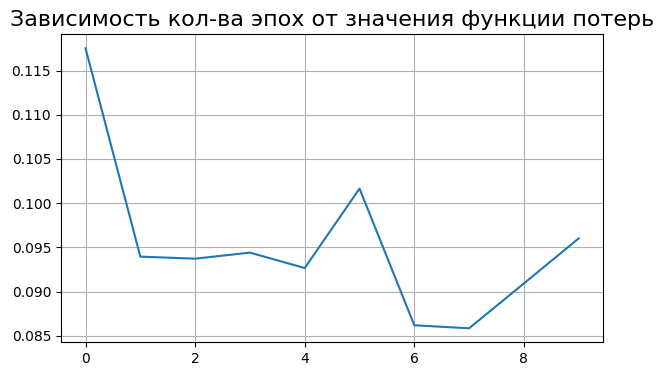

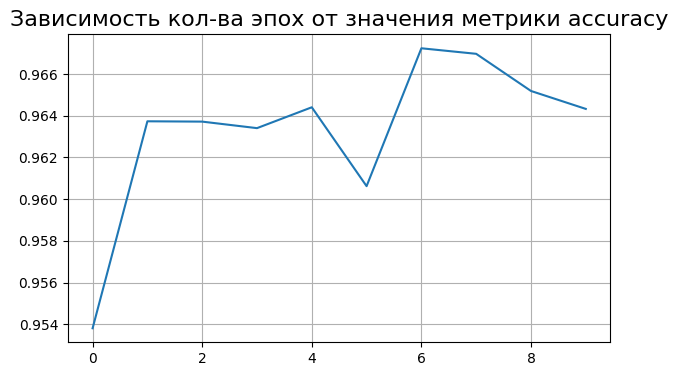

In [18]:
def plot_metrics(metric, caption):
    plt.figure(figsize=(7,4))
    plt.plot(list(range(0, len(metric))), metric)
    plt.title(f'Зависимость кол-ва эпох от значения {caption}', fontsize=16)
    plt.grid()
    

plot_metrics(losses, 'функции потерь')
plot_metrics(accs, 'метрики accuracy')

100%|██████████| 1461/1461 [34:05<00:00,  1.40s/it]


F1 = 0.9505365874612504,Acc = 0.9630356856240971,ROC-AUC = 0.9924795488895427


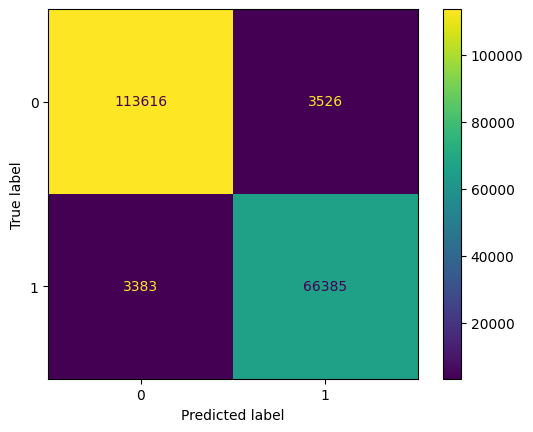

In [19]:
evaluate(test_loader, model)